Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Action taken at step 1: 0
Action taken at step 2: 0
Action taken at step 3: 0
Action taken at step 4: 0
Action taken at step 5: 0
Action taken at step 6: 0
Action taken at step 7: 0
Action taken at step 8: 0
Action taken at step 9: 0
Action taken at step 10: 0
Action taken at step 11: 0
Action taken at step 12: 0
Action taken at step 13: 0
Action taken at step 14: 0
Action taken at step 15: 0
Action taken at step 16: 0
Action taken at step 17: 0
Action taken at step 18: 0
Action taken at step 19: 0
Action taken at step 20: 0
Action taken at step 21: 0
Action taken at step 22: 0
Action taken at step 23: 0
Action taken at step 24: 0
Action taken at step 25: 0
Action taken at step 26: 0
Action taken at step 27: 0
Action taken at step 28: 0
Action taken at step 29: 0
Action taken at step 30: 0
Action taken at step 31: 0
Action taken at step 32: 0
Action taken at step 33: 0
Action taken at step 34: 0
Action taken a

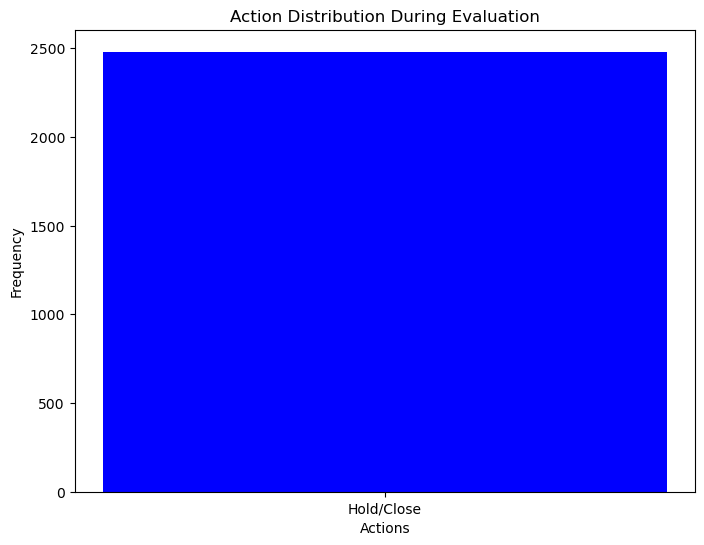

No trades were made by the agent.
No equity changes to plot.


In [3]:
# ================================
# 1. IMPORTING LIBRARIES
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import ta
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.model_selection import train_test_split
from collections import Counter

# ================================
# 2. LOADING AND PREPROCESSING DATA
# ================================
df = pd.read_csv(r'C:\Users\Daniel\Documents\Trading\Trading Bot\EURUSD-H1-2Years.csv', delimiter='\t')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Converting 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'Time' is in datetime.time format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
        
# Feature Engineering: Extracting Hour and Minute, Cyclical Encoding
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)

# Cyclical encoding for Hour (0-23)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for Minute (0-59)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Dropping unnecessary columns
df.drop(['Hour', 'Minute', 'Vol', 'Time', 'Minute_sin', 'Minute_cos'], axis=1, inplace=True)

# ================================
# 3. ADDING TECHNICAL INDICATORS
# ================================
# 1. Simple Moving Averages (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()

# 2. Exponential Moving Averages (EMA)
df['EMA_12'] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
df['EMA_26'] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()

# 3. Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# 5. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# 6. Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

# 7. On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['TickVol']).on_balance_volume()

# 8. Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()

# 9. Commodity Channel Index (CCI)
df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

# 10. Volume-Weighted Average Price (VWAP)
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['TickVol']).volume_weighted_average_price()

# ================================
# 4. HANDLING MISSING VALUES
# ================================
df = df.ffill()  # Forward fill to handle NaNs
df = df.dropna().reset_index(drop=True)  # Drop remaining NaN rows

# ================================
# 5. COMBINING ALL FEATURES AND SCALING
# ================================
# Combine all features (price, volume, and technical indicators) for scaling
features_to_scale = ['Open', 'High', 'Low', 'Close', 'TickVol', 'Spread']
features_to_scale_ti = [
    'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
    'Bollinger_High', 'Bollinger_Low', 'Bollinger_Middle', 'ATR',
    'OBV', 'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP'
]
all_features_to_scale = features_to_scale + features_to_scale_ti

# Scale all combined features at once
scaler = MinMaxScaler()
df[all_features_to_scale] = scaler.fit_transform(df[all_features_to_scale])

# Save the scaler for future use (e.g., during inference or further training)
joblib.dump(scaler, 'scaler.pkl')

# ================================
# 7. DEFINING FOREX TRADING RL ENVIRONMENT
# ================================
class ForexTradingEnv(gym.Env):
    """Custom Environment for Forex Trading (EUR/USD H1)"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(ForexTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0: Hold/Close, 1: Buy, 2: Sell

        # Adjust observation space to match StandardScaler output
        # Assuming StandardScaler scales features to roughly [-5, 5], adjust if necessary
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(23,), dtype=np.float32
        )

        # Initialize trading parameters
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.position = 0  # 0: No position, 1: Long, -1: Short
        self.entry_price = 0
        self.last_price = self.df.iloc[self.current_step]['Close']

        # Risk management parameters
        self.risk_per_trade = 0.01      # 1% of capital
        self.stop_loss_pct = 0.01       # 1% stop loss
        self.max_drawdown_pct = 0.08    # 8% maximum drawdown

        # Leverage
        self.leverage = 100              # 1:100 leverage

        # Initialize position size
        self.position_size = 0           # In units

        # Pip value for EUR/USD
        self.pip_value = 10              # $10 per pip for 1 standard lot (100,000 units)

        # Maximum lot size to prevent unrealistic positions
        self.max_lots = 10               # Example: Maximum 10 standard lots

        # Initialize trade logs
        self.trades = []  # List to store trade information

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Handle seeding if necessary
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.position = 0
        self.entry_price = 0
        self.current_step = 0
        self.last_price = self.df.iloc[self.current_step]['Close']
        self.position_size = 0
        self.trades = []  # Reset trade logs
        observation = self._next_observation()
        info = {}
        return self._next_observation()

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][[
            'Open', 'High', 'Low', 'Close', 'TickVol', 'Spread',
            'Hour_sin', 'Hour_cos', 'SMA_10', 'SMA_50', 'RSI',
            'MACD', 'MACD_Signal', 'MACD_Diff', 'Bollinger_High',
            'Bollinger_Low', 'Bollinger_Middle', 'ATR', 'OBV',
            'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP'
        ]].values
        return obs.astype(np.float32)

    def step(self, action):
        done = False
        reward = 0
        info = {}

        current_price = self.df.iloc[self.current_step]['Close']
        spread = self.df.iloc[self.current_step]['Spread']

        # Adjust prices for spread
        if self.position == 1:
            current_price_adj = current_price - (spread / 2)
        elif self.position == -1:
            current_price_adj = current_price + (spread / 2)
        else:
            current_price_adj = current_price

        # Execute action
        if action == 1:  # Buy
            if self.position == 0:
                # Open new long position
                self.position = 1
                self.entry_price = current_price + (spread / 2)
                self.last_price = self.entry_price

                # Risk management
                self.stop_loss_price = self.entry_price * (1 - self.stop_loss_pct)
                stop_loss_distance = self.entry_price - self.stop_loss_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Buy',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

            elif self.position == -1:
                # Close short position and open long position
                profit_loss = (self.entry_price - current_price_adj) * self.position_size
                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Close Short',
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Open new long position
                self.position = 1
                self.entry_price = current_price + (spread / 2)
                self.last_price = self.entry_price

                # Risk management for new position
                self.stop_loss_price = self.entry_price * (1 - self.stop_loss_pct)
                stop_loss_distance = self.entry_price - self.stop_loss_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Buy',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

        elif action == 2:  # Sell
            if self.position == 0:
                # Open new short position
                self.position = -1
                self.entry_price = current_price - (spread / 2)
                self.last_price = self.entry_price

                # Risk management
                self.stop_loss_price = self.entry_price * (1 + self.stop_loss_pct)
                stop_loss_distance = self.stop_loss_price - self.entry_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Sell',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

            elif self.position == 1:
                # Close long position and open short position
                profit_loss = (current_price_adj - self.entry_price) * self.position_size
                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Close Long',
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Open new short position
                self.position = -1
                self.entry_price = current_price - (spread / 2)
                self.last_price = self.entry_price

                # Risk management for new position
                self.stop_loss_price = self.entry_price * (1 + self.stop_loss_pct)
                stop_loss_distance = self.stop_loss_price - self.entry_price

                # Calculate position size in units with leverage and cap at max_lots
                risk_amount = self.balance * self.risk_per_trade
                calculated_position_size = (risk_amount * self.leverage) / stop_loss_distance
                self.position_size = min(calculated_position_size, self.max_lots * 100000)

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': 'Sell',
                    'price': self.entry_price,
                    'position_size': self.position_size
                })

        elif action == 0:  # Hold or close position
            if self.position != 0:
                # Close existing position
                if self.position == 1:
                    profit_loss = (current_price_adj - self.entry_price) * self.position_size
                    action_type = 'Close Long'
                elif self.position == -1:
                    profit_loss = (self.entry_price - current_price_adj) * self.position_size
                    action_type = 'Close Short'

                self.balance += profit_loss
                self.net_worth = self.balance
                reward += profit_loss

                # Log the trade
                self.trades.append({
                    'step': self.current_step,
                    'action': action_type,
                    'price': current_price_adj,
                    'profit_loss': profit_loss
                })

                # Reset position
                self.position = 0
                self.entry_price = 0
                self.position_size = 0

        # Penalize the 'Hold' action to encourage trading
        if action == 0:
            reward -= 0.01  # Adjust the penalty as needed

        # Check for stop loss
        if self.position == 1 and (current_price_adj <= self.stop_loss_price):
            # Close long position
            profit_loss = (current_price_adj - self.entry_price) * self.position_size
            self.balance += profit_loss
            self.net_worth = self.balance
            reward += profit_loss

            # Log the trade
            self.trades.append({
                'step': self.current_step,
                'action': 'Stop Loss Close Long',
                'price': current_price_adj,
                'profit_loss': profit_loss
            })

            # Reset position
            self.position = 0
            self.entry_price = 0
            self.position_size = 0

        elif self.position == -1 and (current_price_adj >= self.stop_loss_price):
            # Close short position
            profit_loss = (self.entry_price - current_price_adj) * self.position_size
            self.balance += profit_loss
            self.net_worth = self.balance
            reward += profit_loss

            # Log the trade
            self.trades.append({
                'step': self.current_step,
                'action': 'Stop Loss Close Short',
                'price': current_price_adj,
                'profit_loss': profit_loss
            })

            # Reset position
            self.position = 0
            self.entry_price = 0
            self.position_size = 0

        # Calculate reward for holding position
        if self.position != 0:
            # Calculate the profit/loss since the last step
            price_change = current_price_adj - self.last_price
            reward += price_change * self.position * self.position_size

            # Update net worth based on current position
            self.net_worth = self.balance + ((current_price_adj - self.entry_price) * self.position * self.position_size)
        else:
            price_change = 0

        # Update last price
        self.last_price = current_price_adj

        # Update max net worth and check for drawdown
        self.max_net_worth = max(self.max_net_worth, self.net_worth)
        drawdown = (self.max_net_worth - self.net_worth) / self.max_net_worth
        if drawdown >= self.max_drawdown_pct:
            done = True
            reward -= 10  # Penalize for exceeding max drawdown

        # Move to next step
        self.current_step += 1

        # Check if done (end of data)
        if self.current_step >= len(self.df) - 1:
            done = True

        # Gymnasium expects two boolean flags: terminated and truncated
        terminated = done
        truncated = False

        # Scale the reward
        scaled_reward = reward / 1000  # Adjust the divisor based on your data

        return self._next_observation(), scaled_reward, done, info

    def render(self, mode='human', close=False):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: ${self.balance:.2f}')
        print(f'Net Worth: ${self.net_worth:.2f}')
        print(f'Profit: ${profit:.2f}')
        print(f'Position: {"Long" if self.position == 1 else "Short" if self.position == -1 else "None"}')

# ================================
# 8. SPLIT AND PREPROCESS DATA
# ================================
# Split the data into training and testing sets (80-20 split)
training_df, testing_df = train_test_split(df, test_size=0.2, shuffle=False)

# Load the saved scaler from training
scaler = joblib.load('scaler.pkl')

# Define the features that you used during training for scaling
features = ['Open', 'High', 'Low', 'Close', 'TickVol', 'Spread',  # Price and volume data
            'SMA_10', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',  # Technical indicators
            'Bollinger_High', 'Bollinger_Low', 'Bollinger_Middle', 'ATR', 
            'OBV', 'Ichimoku_A', 'Ichimoku_B', 'CCI', 'VWAP']

# Ensure that testing_df contains these features (check for missing columns)
missing_features = set(features) - set(testing_df.columns)
if missing_features:
    raise ValueError(f"Missing features in testing data: {missing_features}")

# Apply the scaler to the testing data and training data
testing_df[features] = scaler.transform(testing_df[features])

# ================================
# 9. INITIALIZE ENVIRONMENT FOR EVALUATION
# ================================
# Initialize the environment with testing data for evaluation
eval_env = ForexTradingEnv(testing_df)

# ================================
# 10. LOAD TRAINED MODEL AND RUN EVALUATION
# ================================
# Load the trained model (ensure that 'ppo_forex_trading.zip' exists)
model = PPO.load("ppo_forex_trading", env=eval_env)

# Run the model on training data to extract trades
obs = eval_env.reset()  # Only unpack the observation

done = False
total_reward = 0
actions_taken = []

# ================================
# 11. EXECUTE ACTIONS AND ACCUMULATE REWARDS
# ================================
while not done:
    # Predict action using the trained model
    action, _states = model.predict(obs, deterministic=True)
    
    # If action is already an integer, no need to convert or index it
    action_value = int(action)
    actions_taken.append(action_value)
    
    # Take action in the environment
    obs, reward, done, info = eval_env.step(action_value)
    total_reward += reward
    
    # Log the action
    current_step = eval_env.current_step
    print(f"Action taken at step {current_step}: {action_value}")

# Remove redundant action and reward steps
print(f"Total reward on evaluation data: {total_reward}")

# ================================
# 12. EXTRACT AND DISPLAY TRADES
# ================================
# Extract trades from the underlying environment
trades = pd.DataFrame(eval_env.trades)
print(trades)

# ================================
# 13. PLOT ACTION DISTRIBUTION
# ================================
action_counts = Counter(actions_taken)
action_mapping = {0: 'Hold/Close', 1: 'Buy', 2: 'Sell'}
action_labels = [action_mapping.get(action, 'Unknown') for action in action_counts.keys()]
action_values = list(action_counts.values())

plt.figure(figsize=(8,6))
plt.bar(action_labels, action_values, color=['blue', 'green', 'red'])
plt.title('Action Distribution During Evaluation')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.show()

# ================================
# 14. PLOT TRADES ON PRICE CHART
# ================================
if not trades.empty:
    plt.figure(figsize=(15,7))
    plt.plot(testing_df['Close'].reset_index(drop=True), label='Close Price', alpha=0.5)
    
    buys = trades[trades['action'] == 'Buy']
    closes_long = trades[trades['action'] == 'Close Long']
    closes_short = trades[trades['action'] == 'Close Short']
    sells = trades[trades['action'] == 'Sell']
    
    # Plot Buy actions
    plt.scatter(buys['step'], buys['price'], marker='^', color='green', label='Buy', alpha=1)
    
    # Plot Close Long actions
    plt.scatter(closes_long['step'], closes_long['price'], marker='v', color='red', label='Close Long', alpha=1)
    
    # Plot Close Short actions
    plt.scatter(closes_short['step'], closes_short['price'], marker='v', color='orange', label='Close Short', alpha=1)
    
    # Plot Sell actions
    plt.scatter(sells['step'], sells['price'], marker='v', color='purple', label='Sell', alpha=1)
    
    plt.title('RL Agent Trades on Testing Data')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
else:
    print("No trades were made by the agent.")

# ================================
# 15. PLOT EQUITY CURVE
# ================================
if not trades.empty:
    net_worths = [eval_env.initial_balance]
    steps = []
    
    obs = eval_env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        net_worths.append(eval_env.net_worth)
        steps.append(eval_env.current_step)
    
    # Plot Equity Curve
    plt.figure(figsize=(15,7))
    plt.plot(steps, net_worths[1:], label='Equity Curve', color='blue')
    plt.title('Equity Curve on Testing Data')
    plt.xlabel('Time Step')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()
else:
    print("No equity changes to plot.")